### Imports

In [1]:
import matplotlib.pyplot as plt
import librosa
from librosa import display
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from os import listdir
from os.path import isdir
import statistics
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
np.random.seed(423)

### Testing area

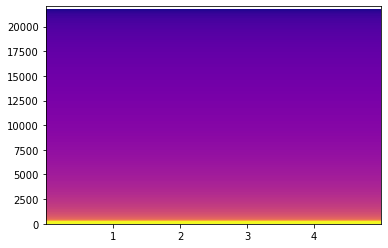

In [163]:
plt.specgram(np.concatenate([np.array(one_second * 5), np.repeat(last_second, 5)]),
    Fs=44100, cmap="plasma", NFFT=256, scale_by_freq=False, scale='dB');


In [10]:
# sample_rate, samples = wavfile.read('../audio_files/mono/sine_440.wav')
# frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# # print(sample_rate, samples)

# # plt.specgram(samples, Fs=440, cmap="rainbow");
# D = np.abs(librosa.stft(librosa.load('../audio_files/mono/sine_440.wav')))
# DB = librosa.amplitude_to_db(D, ref=np.max)
# librosa.display.specshow(DB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='log');



# # plt.pcolormesh(times, frequencies, spectrogram)
# # plt.imshow(spectrogram)
# # plt.ylabel('Frequency [Hz]')
# # plt.xlabel('Time [sec]')
# # plt.show()

(array([ 1092,  1247,  1403, ..., -1557, -1403, -1247], dtype=int16),
 array([   0,  205,  409, ..., -612, -409, -205], dtype=int16))

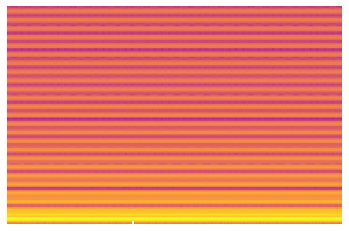

In [178]:
file_name = 'audio_files/mono/one_offs/sine_ableton.wav'

sample_rate, samples = wavfile.read('../' + file_name)
sample_rate, samples2 = wavfile.read('../' + 'audio_files/mono/one_offs/sine_440.wav')
# frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# print(sample_rate, samples)
# plt.figure(figsize=(12, 8))
with plt.ioff():
    plt.specgram(samples[:, 0], Fs=sample_rate, cmap="plasma", NFFT=256);
    plt.axis('off');
# plt.savefig('test.png', bbox_inches='tight')

# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()
samples[:, 0], samples2

In [39]:
# for i in samples[:, 0][44100*6:44100*7]:
#     print(i)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [14]:
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# from matplotlib.figure import Figure

# fig = plt.Figure()
# ax = fig.add_subplot(111)
# ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256)
# ax.axis('off');
# canvas = FigureCanvas(fig)
# canvas.print_figure('sample.png', bbox_inches='tight')

In [17]:
# im = load_img('../audio_files/mono/basic_waves_ads/sine/ads_A♯5_9.png')

In [3]:
[4] * 4

[4, 4, 4, 4]

In [18]:
# img_to_array(im).shape

### Function for making visualizations using the .wav samples

In [4]:
def wav_to_plots(folder_name, spec=True, adsr=True):
    wav_path = f'../audio_files/mono/{folder_name}/wavs'
    spec_path = f'../audio_files/mono/{folder_name}/spectrograms'
    adsr_path = f'../audio_files/mono/{folder_name}/adsr_plots'

    for subfolder in listdir(wav_path):
        if isdir(f'{wav_path}/{subfolder}'):
            for w in listdir(f'{wav_path}/{subfolder}'):
                # spectrograms
                try:
                    if (spec):
                        sample_rate, samples = wavfile.read(f'{wav_path}/{subfolder}/{w}')
                        with plt.ioff():
                            # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
                            fig = plt.Figure()
                            ax = fig.add_subplot(111)
                            ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                            ax.axis('off')
                            canvas = FigureCanvas(fig)
                            canvas.print_figure(f'{spec_path}/{subfolder}/{w}.png', bbox_inches='tight')
                    if (adsr):
                        audio_sample = librosa.load(f'{wav_path}/{subfolder}/{w}')
                
                        with plt.ioff():
                            fig = plt.Figure()
                            ax = fig.add_subplot(111)
                            ax.plot(audio_sample[0])
                            ax.axis('off')
                            canvas = FigureCanvas(fig)
                            w_name = w.split('.')[0]
                            canvas.print_figure(f'{adsr_path}/{subfolder}_{w_name}.png', bbox_inches='tight')
                except: # catches the .DS_Store files
                    print(f'Error with file at {wav_path}/{subfolder}/{w}')
                
                # adsr plots
                
                


## Modeling

### CNN Models - Group 1 (basic_waves)

##### Four different waveforms, 12 notes, 5 octaves (2-6) - No variation in adsr, other modulation

~~ADS (R not included until I figure how to trigger release in the sample generation script)~~

#### Model 1.1 - CNN - Identifying the waveforms - no modulations

In [165]:
# data gen
datagen = ImageDataGenerator(validation_split=0.2)

train_gen = datagen.flow_from_directory(
    '../audio_files/mono/basic_waves/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_directory(
    '../audio_files/mono/basic_waves/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
model = Sequential()

model.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(35, activation='relu'))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=4
)

mc = ModelCheckpoint(
    filepath='models/model1.1mc{epoch:02d}-{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.85
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=25, callbacks=[es, mc])

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
 1/13 [=>............................] - ETA: 36s - loss: 56.5128 - accuracy: 0.1250

KeyboardInterrupt: 

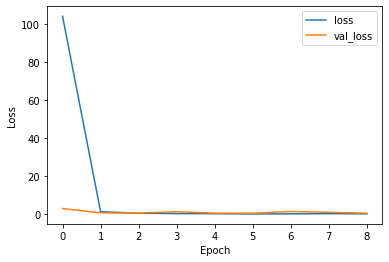

In [6]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

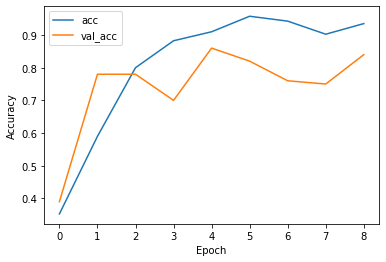

In [7]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])

In [8]:
preds = model.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(y_true=test_gen.classes, y_pred=np.argmax(preds, axis=1), labels=test_gen.class_indices.values)

TypeError: '<' not supported between instances of 'builtin_function_or_method' and 'int'

In [39]:
np.argmax(preds, axis=1), test_gen.classes

(array([1, 0, 0, 3, 3, 1, 3, 0, 0, 0, 1, 1, 2, 0, 3, 3, 3, 1, 3, 1, 1, 0,
        1, 2, 2, 3, 1, 3, 2, 2, 1, 3, 2, 3, 0, 2, 0, 1, 2, 3, 2, 0, 3, 3,
        2, 0, 1, 1, 1, 0, 1, 3, 1, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 1, 3, 0,
        2, 0, 1, 3, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 3, 2, 1, 2, 1, 3, 3,
        1, 0, 3, 3, 2, 0, 3, 1, 1, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32))

In [70]:
# model.save('models/model1.1-basic_waves') # 89% val accuracy on final epoch

INFO:tensorflow:Assets written to: models/model1.1-basic_waves/assets


In [32]:
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

In [46]:
model = tf.keras.models.load_model('models/model1.1mc13-0.92')

In [48]:
# predict an image

img_file_path = '../' + 'audio_files/mono/basic_waves/saw/ads_A♯5_24.png'

img_array = img_to_array(load_img(img_file_path, target_size=(389, 515)))
img_batch = np.expand_dims(img_array, axis=0)
# img_preprocessed = preprocess_input(img_batch)
[key for key, val in train_gen.class_indices.items() if val == model.predict(img_batch).argmax(-1)[0]][0]

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x1a2462930>

/Users/kalebtsegaye/opt/anaconda3/envs/live-params/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


array([  0, 255, 255, ..., 255, 255, 255], dtype=uint8)

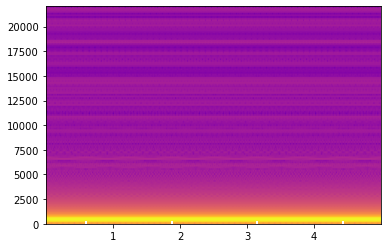

In [71]:
file_name = 'audio_files/mono/one_offs/sine_400.wav'

# predict an image

with plt.ioff():
    # plt.figure(figsize=(12, 8))
    # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
    sample_rate, samples = wavfile.read('../' + file_name)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256)
    # ax.axis('off')
    # code from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    # data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


# img_batch = np.expand_dims(img_array, axis=0)
# # img_preprocessed = preprocess_input(img_batch)
# [key for key, val in train_gen.class_indices.items() if val == model.predict(img_batch).argmax(-1)[0]][0]
data

### Group 2 (2_basic_waves_adsr)

In [15]:
group_folder_name = '2_basic_waves_adsr'

In [47]:
wav_to_plots(folder_name=group_folder_name)

/Users/kalebtsegaye/opt/anaconda3/envs/live-params/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Error with file at ../audio_files/mono/2_basic_waves_adsr/wavs/sq/.DS_Store
Error with file at ../audio_files/mono/2_basic_waves_adsr/wavs/tri/.DS_Store
Error with file at ../audio_files/mono/2_basic_waves_adsr/wavs/sine/.DS_Store


#### Model 2.1 - CNN - Identifying the waveforms - ADSR modulation

Still 12 notes, now 9 octaves (1-9), and, of course, adsr

In [64]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

folder_name = '2_basic_waves_adsr'
spec_path = f'../audio_files/mono/{folder_name}/spectrograms'

train_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
model2_1 = Sequential()

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Flatten())
model2_1.add(Dense(35, activation='relu'))
model2_1.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=7
)

mc = ModelCheckpoint(
    filepath='models/model2.1mc{epoch:02d}-val_acc{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.75
)

model2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2_1 = model2_1.fit(train_gen, validation_data=test_gen, epochs=25, callbacks=[es, mc])

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
13/13 [==============================] - 6s 434ms/step - loss: 1.2651 - accuracy: 0.4325 - val_loss: 0.8888 - val_accuracy: 0.6500
Epoch 2/25
13/13 [==============================] - 5s 419ms/step - loss: 0.8707 - accuracy: 0.5575 - val_loss: 0.8139 - val_accuracy: 0.5800
Epoch 3/25
13/13 [==============================] - 5s 433ms/step - loss: 0.7765 - accuracy: 0.6000 - val_loss: 0.7503 - val_accuracy: 0.6500
Epoch 4/25
13/13 [==============================] - 5s 417ms/step - loss: 0.7509 - accuracy: 0.6375 - val_loss: 0.7469 - val_accuracy: 0.6200
Epoch 5/25
13/13 [==============================] - 6s 419ms/step - loss: 0.7114 - accuracy: 0.6450 - val_loss: 0.7759 - val_accuracy: 0.5400
Epoch 6/25
13/13 [==============================] - 6s 421ms/step - loss: 0.6800 - accuracy: 0.6875 - val_loss: 0.6645 - val_accuracy: 0.6400
Epoch 7/25
13/13 [==============================] - 6s 424ms/step 

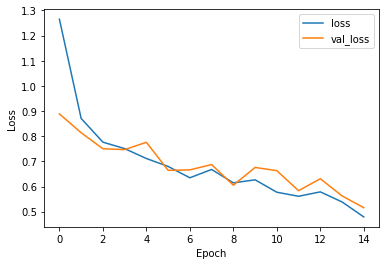

In [65]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.legend(['loss', 'val_loss'])

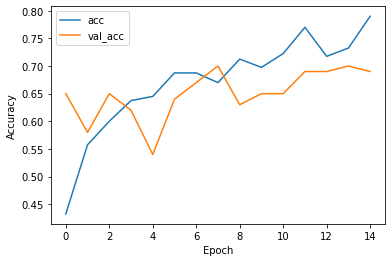

In [66]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2_1.history['accuracy'])
plt.plot(history2_1.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])

##### Labels:

In [32]:
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

##### Loading model, testing model

In [37]:
model = tf.keras.models.load_model('models/model2.1mc15-val_acc0.88')

In [34]:
# predict an image
folder_name = '2_basic_waves_adsr'
spec_path = f'../audio_files/mono/{folder_name}/spectrograms'

predictions = {'sine':[], 'saw':[], 'sq':[], 'tri':[]}

for subfolder in listdir(spec_path):
    if isdir(f'{spec_path}/{subfolder}'):
        for w in listdir(f'{spec_path}/{subfolder}'):
            # try:
            img_array = img_to_array(load_img(f'{spec_path}/{subfolder}/{w}', target_size=(389, 515)))
            img_batch = np.expand_dims(img_array, axis=0)
            predictions[subfolder].append(model.predict(img_batch).argmax(-1)[0])

In [35]:
for key, val in predictions.items():
    print(key, statistics.mode(val), val.count(statistics.mode(val))/len(val))

sine 1 0.456
saw 0 0.896
sq 0 0.52
tri 3 0.312


#### Model 2.2: ADSR Estimation

In [16]:
data = pd.read_csv(f'../audio_files/mono/{group_folder_name}/file_data.csv').drop('Unnamed: 0', axis = 1)

In [30]:
data['file_name'] = data['file_name'] + '.png'
data

file_name       wave note  octave note_octave  \
0     sine/adsr_D♯5_1.wav.png  sine/adsr   D♯       5         D♯5   
1      sine/adsr_E6_2.wav.png  sine/adsr    E       6          E6   
2      sine/adsr_C1_3.wav.png  sine/adsr    C       1          C1   
3      sine/adsr_G8_4.wav.png  sine/adsr    G       8          G8   
4     sine/adsr_C♯4_5.wav.png  sine/adsr   C♯       4         C♯4   
..                        ...        ...  ...     ...         ...   
495   saw/adsr_B3_121.wav.png   saw/adsr    B       3          B3   
496   saw/adsr_D9_122.wav.png   saw/adsr    D       9          D9   
497  saw/adsr_G♯2_123.wav.png   saw/adsr   G♯       2         G♯2   
498  saw/adsr_D♯1_124.wav.png   saw/adsr   D♯       1         D♯1   
499   saw/adsr_E7_125.wav.png   saw/adsr    E       7          E7   

            freq  attack_duration  decay_duration  sustain_level  \
0     622.253967         4.013292        1.263828       0.723298   
1    1318.510228         1.617495        2.929420       0.744542   
2      32.703196         4.265106        1.609075       0.187103   
3    6271.926976         0.918339        2.958791       0.688149   
4     277.182631         2.069040        3.987323       0.643333   
..           ...              ...             ...            ...   
495   246.941651         0.675360        0.863886       0.463540   
496  9397.272573         4.256398        0.194066       0.034862   
497   103.826174         2.858531        3.777678       0.290850   
498    38.890873         3.262614        2.066049       0.677198   
499  2637.020455         2.332231        2.664905       0.323182   

     sustain_duration  release_duration  
0            3.441122          1.159768  
1            2.059110          1.812222  
2            1.099399          2.429497  
3            1.085055          1.506915  
4            0.276730          1.975747  
..                ...               ...  
495          3.391712          1.920458  
496          3.142168          2.407368  
497          0.093278          0.389784  
498          3.107983          1.563354  
499          2.137675          2.865189  

[500 rows x 11 columns]

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         500 non-null    object 
 1   wave              500 non-null    object 
 2   note              500 non-null    object 
 3   octave            500 non-null    int64  
 4   note_octave       500 non-null    object 
 5   freq              500 non-null    float64
 6   attack_duration   500 non-null    float64
 7   decay_duration    500 non-null    float64
 8   sustain_level     500 non-null    float64
 9   sustain_duration  500 non-null    float64
 10  release_duration  500 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 43.1+ KB


In [29]:
print(group_folder_name)

2_basic_waves_adsr


In [32]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

y_cols = ['attack_duration', 'decay_duration', 'sustain_level',	'sustain_duration',	'release_duration']

train_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='validation'
)

folder_name = '2_basic_waves_adsr'
adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

model2_2 = Sequential()

model2_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model2_2.add(MaxPooling2D(pool_size=(4,4)))

model2_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model2_2.add(MaxPooling2D(pool_size=(4,4)))

model2_2.add(Flatten())
model2_2.add(Dense(35, activation='relu'))
model2_2.add(Dense(5))

es = EarlyStopping(
    monitor = 'val_mean_squared_error',
    verbose = 1,
    mode='min',
    patience=7
)

mc = ModelCheckpoint(
    filepath='models/model2.2mc{epoch:02d}-val_mse{val_mean_squared_error:.2f}',
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.5
)

model2_2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

history2_2 = model2_2.fit(
    train_gen,
    validation_data=test_gen,
    # y=y_cols,
    # y=
    epochs=25,
    callbacks=[es, mc])

Found 400 validated image filenames.
Found 100 validated image filenames.
Epoch 1/25
 4/13 [========>.....................] - ETA: 15s - loss: 3.7014 - mean_absolute_error: 1.5543 - mean_squared_error: 3.7014

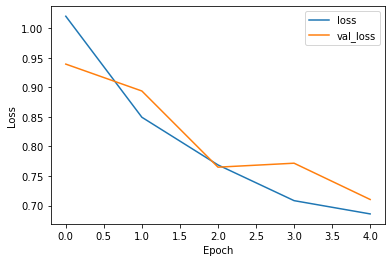

In [127]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2_2.history['loss'])
plt.plot(history2_2.history['val_loss'])
plt.legend(['loss', 'val_loss'])

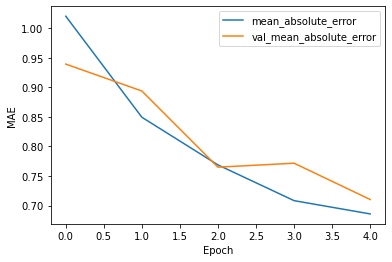

In [128]:
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(history2_2.history['mean_absolute_error'])
plt.plot(history2_2.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])

In [91]:
audio_sample = librosa.load('../audio_files/mono/2_basic_waves_adsr/wavs/saw/adsr_A♯1_42.wav')

In [27]:
data.head()

file_name       wave note  octave note_octave         freq  \
0  sine/adsr_D♯5_1.wav  sine/adsr   D♯       5         D♯5   622.253967   
1   sine/adsr_E6_2.wav  sine/adsr    E       6          E6  1318.510228   
2   sine/adsr_C1_3.wav  sine/adsr    C       1          C1    32.703196   
3   sine/adsr_G8_4.wav  sine/adsr    G       8          G8  6271.926976   
4  sine/adsr_C♯4_5.wav  sine/adsr   C♯       4         C♯4   277.182631   

   attack_duration  decay_duration  sustain_level  sustain_duration  \
0         4.013292        1.263828       0.723298          3.441122   
1         1.617495        2.929420       0.744542          2.059110   
2         4.265106        1.609075       0.187103          1.099399   
3         0.918339        2.958791       0.688149          1.085055   
4         2.069040        3.987323       0.643333          0.276730   

   release_duration  
0          1.159768  
1          1.812222  
2          2.429497  
3          1.506915  
4          1.975747

In [129]:
img_array = img_to_array(load_img('../audio_files/mono/2_basic_waves_adsr/adsr_plots/sine/adsr_D♯5_1.wav.png', target_size=(256, 256)))
img_batch = np.expand_dims(img_array, axis=0)
model2_2.predict(img_batch)

array([[922.7301 , 549.87177,   0.     , 610.4364 , 374.13962]],
      dtype=float32)

In [130]:
# predict an image
folder_name = '2_basic_waves_adsr'

for subfolder in listdir(adsr_path):
    if isdir(f'{adsr_path}/{subfolder}'):
        for w in listdir(f'{adsr_path}/{subfolder}'):
            # try:
            img_array = img_to_array(load_img(f'{adsr_path}/{subfolder}/{w}', target_size=(256, 256)))
            img_batch = np.expand_dims(img_array, axis=0)
            print(f'{subfolder},{w}', model2_2.predict(img_batch))
            break


sq,adsr_B3_1.wav.png [[601.9072  688.4092    0.      588.0194  590.22284]]
tri,adsr_C6_59.wav.png [[810.29626 556.4661    0.      467.47903 479.09677]]
saw,adsr_G♯7_102.wav.png [[377.96375 704.78394   0.      706.8578  738.5076 ]]
sine,adsr_G♯2_32.wav.png [[188.5473  527.8464    0.      658.20306 660.7602 ]]


#### Messing around with librosa

In [5]:
audio_sample = librosa.load('../audio_files/mono/2_basic_waves_adsr/wavs/saw/adsr_A♯1_42.wav')

In [6]:
avg_length = 22050*0.001/22050
avg_length = 22 # approx how many samples represent 0.001 seconds

avg_samp = []
for i in range(0, len(audio_sample[0]), avg_length):
    avg = None
    if i + 22 < len(audio_sample[0]) - 1:
        avg = statistics.mean(audio_sample[0][i:i+22])
    else:
        avg = statistics.mean(audio_sample[0][i:len(audio_sample[0])])
    
    avg_samp.append(avg)

In [33]:
x = 22*0.001/22.05
x

0.0009977324263038547

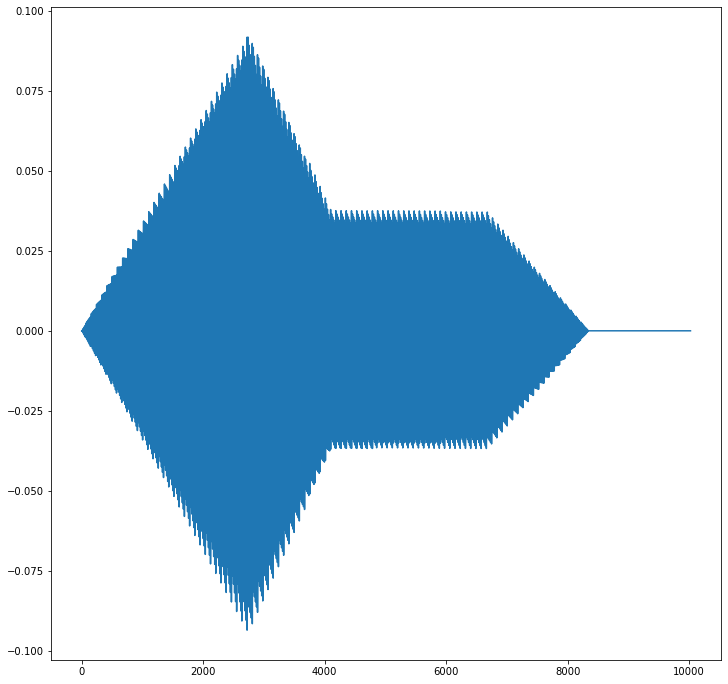

In [37]:
plt.figure(figsize=(12,12))
plt.plot(avg_samp)

In [7]:
db = librosa.amplitude_to_db(audio_sample[0], ref=np.max)

for i in range(0, len(db), len(db)//10):
    print(db[i])

-80.0
-10.204128
-11.522221
-20.523863
-11.899454
-11.218433
-21.131235
-22.040033
-25.018137
-80.0


In [18]:
data[data['file_name'].str.contains('saw/adsr_A♯1_42')]

file_name      wave note  octave note_octave      freq  \
416  saw/adsr_A♯1_42.wav  saw/adsr   A♯       1         A♯1  58.27047   

     attack_duration  decay_duration  sustain_level  sustain_duration  \
416         2.736728        1.360167       0.397736          2.570345   

     release_duration  
416          1.658465

In [12]:
def find_adsr(audio_file):
    sr = audio_file[1]
    db = librosa.amplitude_to_db(audio_file[0])

    peak = np.amax(db)
    peak_index = np.where(db == peak)

    # find start of sound
    curr = peak_index
    curr_avg_range = 
    for i in range(peak_index-20, 0, -20):
        if db[i] < curr:
            curr = db[i]
        else:

    return peak_index[0]/sr

find_adsr(audio_sample)

array([2.73287982])

In [26]:
librosa.amplitude_to_db(audio_sample[0])[40]

-90.16934

In [108]:
np.where(audio_sample[0] == max(audio_sample[0]))
np.where(librosa.amplitude_to_db(audio_sample[0], ref=np.max) >= 0)

(array([60260]),)

In [110]:
sign = 1 if librosa.amplitude_to_db(audio_sample[0], ref=np.max) >= 0 else -1
for idx, i in enumerate(librosa.amplitude_to_db(audio_sample[0], ref=np.max)):
    if i < 0:
        print('negative')
    if sign == 1:
        if i >= 0:
            pass
        else:
            print(f'sign_change at {idx}')
            sign = -1
    elif sign == -1:
        if i >= 0:
            print(f'sign_change at {idx}')
            sign = 1
        else:
            pass

negative
sign_change at 1
negative
sign_change at 2
sign_change at 3
negative
sign_change at 4
sign_change at 5
negative
sign_change at 6
sign_change at 7
negative
sign_change at 8
sign_change at 9
negative
sign_change at 10
sign_change at 11
negative
sign_change at 12
sign_change at 13
negative
sign_change at 14
negative
sign_change at 16
negative
sign_change at 17
sign_change at 18
negative
sign_change at 19
sign_change at 20
negative
sign_change at 21
sign_change at 22
negative
sign_change at 23
sign_change at 24
negative
sign_change at 25
sign_change at 26
negative
sign_change at 27
sign_change at 28
negative
sign_change at 95
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
n

In [5]:
prev = (librosa.amplitude_to_db(audio_sample[0], ref=np.max)[0])
for idx, i in enumerate(librosa.amplitude_to_db(audio_sample[0], ref=np.max)[1:]):
    curr = i

    if i > prev:
        print(idx, 'going up!')
    elif i < prev:
        print(idx, 'going down!')

    prev = curr

28 going up!
29 going down!
30 going up!
31 going down!
32 going down!
33 going up!
34 going down!
35 going up!
36 going down!
37 going up!
38 going down!
39 going up!
40 going down!
41 going up!
42 going down!
43 going up!
44 going down!
45 going down!
46 going up!
47 going down!
48 going up!
49 going up!
50 going down!
51 going up!
52 going down!
53 going up!
54 going down!
55 going up!
56 going down!
57 going down!
58 going up!
59 going down!
60 going up!
61 going down!
62 going up!
63 going down!
64 going up!
65 going up!
66 going down!
67 going up!
68 going down!
69 going down!
70 going up!
71 going down!
72 going up!
73 going down!
74 going up!
75 going down!
76 going up!
77 going down!
78 going up!
79 going up!
80 going up!
81 going down!
82 going up!
83 going down!
84 going up!
85 going down!
86 going up!
87 going down!
88 going up!
89 going down!
90 going up!
91 going up!
92 going up!
93 going up!
94 going down!
95 going up!
96 going down!
97 going up!
98 going down!
99 going 

In [8]:
.001/(22.05/22050)

1.0

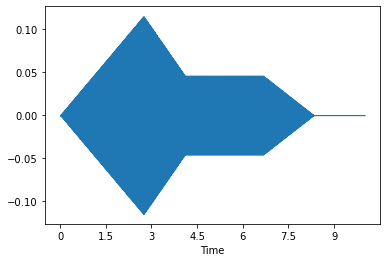

In [77]:
display.waveshow(audio_sample[0])
# display.specshow(audio_sample[0])
# D = np.abs(librosa.stft(audio_sample))
# DB = librosa.amplitude_to_db(D, ref=np.max)
# librosa.display.specshow(DB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='log');


In [63]:
with plt.ioff():
    fig = plt.Figure()
    ax = fig.add_subplot(111)
    print(type(ax))
    # ax.ax display.waveshow(audio_sample[0])
    ax.axis('off')
    canvas = FigureCanvas(fig)
    canvas.print_figure(f'test2.png', bbox_inches='tight')


<class 'matplotlib.axes._subplots.AxesSubplot'>


In [ ]:
# including outside libraries
# recall, precision
# more relu layers if overfitting, dropout layers for overfitting